**author**: amnonim@gmail.com, a3tripat@ucsd.edu<br>
**date**: 27 Feb 2017<br>
**language**: Python 3.5<br>
**conda enviroment**: emp-py3<br>
**license**: unlicensed<br>

## entropy_sample_type_vs_taxa.ipynb

In [1]:
import biom
import pandas as pd
import numpy as np
import time

#for ordering
from scipy import cluster,spatial,stats 
import skbio.diversity.alpha

np.random.seed(2016)

In [3]:
#loading biom table
table=biom.load_table('/Users/luke.thompson/emp/otu-tables/deblur/emp_deblur_90bp.subset_2k.rare_5000.biom')

In [4]:
#loading mapping file
mapfile=pd.read_table('/Users/luke.thompson/emp/metadata-refine/emp_qiime_mapping_subset_2k.tsv',dtype=str, sep="\t")
mapfile=mapfile.set_index("#SampleID")

In [5]:
#get all OTUs
obs_arr=(table.ids('observation'))
len(obs_arr)

155002

In [6]:
#get sample ids
sample_arr=table.ids('sample')
len(sample_arr) #number of samples in the table

2000

In [7]:
map_field_name='empo_3'
sample_env={} #dictionary to store env for each sample
for sample in sample_arr:
    sample_env[sample]=mapfile.ix[sample,map_field_name]

In [8]:
env_mat_list=['Animal surface','Animal corpus','Animal secretion','Animal proximal gut','Animal distal gut','Plant surface','Plant corpus','Plant rhizosphere','Soil (non-saline)','Sediment (non-saline)','Sediment (saline)','Surface (non-saline)','Surface (saline)','Aerosol (non-saline)','Water (non-saline)','Water (saline)','Intertidal (saline)','Hypersaline (saline)','Sterile water blank','Mock community']
env_mat_pos={} #a dict for env_mat:position in weight list
number_env_mat=len(env_mat_list)
for pos in range(number_env_mat):
    env_mat_pos[env_mat_list[pos]]=pos

In [9]:
permuted_otus=np.random.permutation(obs_arr) #permuting obs_arr to remove biases due to ordering of studies in orignal data

Below is the code segment to calculate the weightage of each empo category for _all_ taxonomic levels. 
We take each otu and 

1. make a list of empo categories it is _present_ (abundance not accounted for) in
2. make a list of taxonomic bins it belongs to and 
3. calculate its 'weight' such that weight of otu= 1/(number of samples an otu is present in). 

Then we use a list (sample_wt_list) which is ordered such that each index corresponds to a unique empo3 category. We add the weight of each otu at the positions corresponding to empo3 categories that otu is present in. Once we have this list, we store it in a dictionary (result= {taxa_bin: sample_wt_list}) for each taxonomic bin that otu belongs to. For otus belonging to one or more overlapping taxonomic bins, their sample_wt_list gets added and the key-value pair (result[taxa_bin]) gets modified. 

In the end, we get a dict (result) which is a dict of lists such that keys are a comprehensive list of taxonomic bins and values are a list of weights of the taxonomic bin for all empo3 categories. 

In [10]:
#calculating weights of constituent environment types for taxonomic bins
result={}
t1=time.time()
numperclass={}
for otu in permuted_otus[:]:
    otu_freq=table.data(otu,axis='observation', dense=True) #a list of frequencies of an otu across samples
    taxa_bins=[]
    env_present=[]
    sample_wt_list=np.zeros(number_env_mat)
    wt=1/float(np.count_nonzero(otu_freq)) #wt=1/(number of samples an otu is present in) 
    nz_ind=otu_freq !=0 #stores positions corresponding to samples where the otu frequency is non-zero
    for i in range(len(nz_ind)):
        if nz_ind[i]:
            env_present.append(sample_env[sample_arr[i]]) #making a list of environments each otu is present in
   
    taxa=table.metadata(otu,'observation')['taxonomy'] #extracting taxonomy information for each otu
    for i in range(len(taxa)): #loop to remove unknown classification levels (eg. 's__')
        if len(taxa[i]) <= 3:
            taxa=taxa[:i]
            break
    
    for i in range(len(taxa)): #loop to get all the taxonomic bins that an otu falls into 
        taxa_bins.append(';'.join(taxa))
        taxa.pop() #removing the last element of the classification
    for env in env_present: #looping over all the environments an otu is present in
        sample_wt_list[env_mat_pos[env]]=sample_wt_list[env_mat_pos[env]]+wt #adding wt to corresponding positions for each environment
    
    for taxa_bin in taxa_bins: #looping over all the taxa bins an otu is associated with
        if taxa_bin not in result.keys():
            result[taxa_bin]= sample_wt_list
            numperclass[taxa_bin]=1
        else:
            result[taxa_bin]=result[taxa_bin]+sample_wt_list
            numperclass[taxa_bin]+=1
print(len(result))
t2=time.time()
print(t2-t1)

2901
86.98142313957214


In [11]:
#normalizing result{} between 0 to 1
for key in result:
    result[key]=result[key]/sum(result[key])

In [12]:
# create a list of all phyla in the dataset
all_phyla = {}
phyla_set = {} #stores number of otus belonging to a phyla
for otu in obs_arr:
    taxa=table.metadata(otu,'observation')['taxonomy']
    if len(taxa)<2:
        continue
    if taxa[1] in phyla_set:
        phyla_set[taxa[1]]+=1
    else:
        phyla_set[taxa[1]]=1
idx=1
allk=[]
allv=[]
for k,v in phyla_set.items():
    allk.append(k)
    allv.append(v)

sv=np.argsort(allv) #sorting phyla by the number of otus in each phyla. Stores indeces to be sorted by.
for uniqnum, idx in enumerate(sv[-10:]):
    all_phyla[allk[idx]]=uniqnum+1 #storing top phyla and unique number for each phyla for color etc. 
idx+=1

In [13]:
all_phyla

{'p__Acidobacteria': 6,
 'p__Actinobacteria': 5,
 'p__Bacteroidetes': 7,
 'p__Chloroflexi': 8,
 'p__Cyanobacteria': 2,
 'p__Firmicutes': 3,
 'p__OP3': 1,
 'p__Planctomycetes': 9,
 'p__Proteobacteria': 10,
 'p__Verrucomicrobia': 4}

In [14]:
'''calculate the per-sub-otu distribution. Similar to the code segment for making the dict 'result' except instead of
storing weights for each taxa_bin, we store weights for each otu itself'''
MINIMAL_SAMPLES = 10 # each otu should be present in atleast MINIMAL_SAMPLES to be considered as a real feature
otu_result={} 
otu_numperclass={} 
t1=time.time()
num_not_enough = 0
for otu in permuted_otus[:]:    
    otu_freq=table.data(otu,axis='observation', dense=True) #a list of frequencies of an otu across samples
    if np.count_nonzero(otu_freq)<MINIMAL_SAMPLES:
        num_not_enough += 1
        continue
    env_present=[]
    sample_wt_list=np.zeros(number_env_mat)
    wt=1/float(np.count_nonzero(otu_freq)) #wt=1/(number of samples an otu is present in) 
    nz_ind=otu_freq !=0
    for i in range(len(nz_ind)):
        if nz_ind[i]:
            env_present.append(sample_env[sample_arr[i]])
    for env in env_present: #looping over all the environments an otu is present in
        sample_wt_list[env_mat_pos[env]]=sample_wt_list[env_mat_pos[env]]+wt #adding wt to corresponding positions for each environment
    otu_result[otu]=sample_wt_list
    otu_numperclass[otu]=1 #as each otu is unique
print('number otus in >= %d samples: %d' % (MINIMAL_SAMPLES, len(otu_result)))
print('number otus in < %d samples: %d' % (MINIMAL_SAMPLES, num_not_enough))
t2=time.time()
print(t2-t1)

number otus in >= 10 samples: 18407
number otus in < 10 samples: 136595
40.29809594154358


In [15]:
# for plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [16]:
def filter_tax_level(result,level,minbacteria=10):
    """
    Make a dict of results for a given taxonomic level

    input:
    result - the main result dict
    level : int
        the taxonomic level to filter (1=Phyla, 2=Order, etc.)
        -1 to not filter
    minbacteria : int
        the minimal number of bacteria in the taxonomic group in order to keep

    output:
    fresult : dict of np-array
        like result, but only for entries of the given level
    """
    if level==-1:
        return result
    fresult={}
    for key in result:
        if len(key.split(';'))==level+1:
                if numperclass[key]>minbacteria: #choosing taxa bins with atleast minbacteria
                    fresult[key]=result[key]
    return fresult

In [17]:
cnames = {u'p__Acidobacteria': '#0000FF',
 u'p__Actinobacteria': '#A52A2A',
 u'p__Bacteroidetes': '#008B8B',
 u'p__Chloroflexi': '#DEB887',
 u'p__Cyanobacteria': '#B8860B',
 u'p__Firmicutes': '#D2691E',
 u'p__Gemmatimonadetes': '#A9A9A9',
 u'p__Planctomycetes': '#A0522D',
 u'p__Proteobacteria': '#556B2F',
 u'p__Verrucomicrobia': '#9932CC',
'others':                '#000000'}

In [18]:
def PlotTaxEnv(result, numperclass, level, taxa=None, reorder=False, showx=True, num_otu=None, all_phyla=None, wide=False):
    '''Plot the empo_3 distribution bars 
    
    Parameters
    ----------
    result : dict of np-array
        key is taxonomy or otuid, value is np-array of weighted freq. of each empo_3 category
    numperclass : dict of int
        key is taxonomy or otuid, value is number of otus with this taxonomy
    level : int
        The phylogenetic level to display (0-Kingdom,1-phylum, etc.)
        -1 to skip level filtering (for otus instead of taxonomy bins)
    taxa : str or None
        show only at otus from this taxonomy (usually 1 lower than level)
    reorder : bool
        True to reorder the taxonomy based on clustering of empo_3 freq.
    showx : bool
        True to show the x-axis (taxonomy) labels
    num_otu : int or None
        if None, use all taxonomies/otus
        if int, randomly keep only int otus to display (useful when displaying the otu level)
    allphyla : dict of (str,int) or None
        key is the phyla, value is the index number for color
        None to skip phyla bar plotting
    returns: a handle for the figure generated
        
    '''
    #keeping classes that belong to a given taxa i.e. if we want all bins that have firmicutes and so on
    if taxa is None:
        sublist = filter_tax_level(result,level)
        fresult=sublist
        taxaname='all reads'
    else:
        fresult=filter_tax_level(result,level)
        sublist={}
        for key in fresult.keys():
            if taxa in key.split(';'):
                sublist[key]=fresult[key]
        taxaname=taxa

    if num_otu is not None:
        # randomly take a subset of the dict entries (sublist)
        keys = list(sublist.keys())
        rp = np.random.permutation(keys)
        newlist={}
        for ckey in rp[:num_otu]:
            newlist[ckey]=sublist[ckey]
        sublist = newlist
        
    key_list=[] #a list of all taxlevel taxa bins
    xticks=[] #a list of x axis lables i.e ONLY taxlevel level name
    color=[]
    for key in sublist: # making a list of all the taxa bins from the result dictionary
        key_list.append(key)
        xticks.append(key.split(';')[level]+'('+str(numperclass[key])+')') #only keeping the taxlevel classification for x axis labels

    if len(sublist)>1:
        if reorder:
            # re-order bacterial taxonomy groups according to euclidean distance
            result_df=pd.DataFrame(index=key_list, columns=env_mat_list) #df to store weighted frequencies of class level taxa_bins for each environment type
            for idx in result_df.index:
                for i in range(len(env_mat_list)):
                    result_df.ix[idx,env_mat_list[i]]=fresult[idx][i]

            dm=spatial.distance.pdist(result_df,metric='euclidean')
            ll=cluster.hierarchy.single(dm)
            order=cluster.hierarchy.leaves_list(ll)

            key_list = [ key_list[i] for i in order]
            xticks = [ xticks[i] for i in order]

    color=['DarkGoldenRod','yellow','sandybrown','tan','saddlebrown','MediumSpringGreen','lawngreen','darkgreen','red','lightsalmon','tomato','black','dimgrey','lightgrey','navy','royalblue','PaleTurquoise','lightskyblue','violet','fuchsia']
    ind=np.arange(len(key_list))
    sns.set_style('whitegrid', {'axes.grid' : False})
    
    if (wide == True):
        fig = plt.figure(figsize=(20,9))
    else:
        fig = plt.figure()

    [ax1_x, ax1_y, ax1_w, ax1_h] = [0.0, 0.0, 1.0, 0.03]
    [axm_x, axm_y, axm_w, axm_h] = [0.0, 0.06 , 1.0 ,0.96]
    [axc_x, axc_y, axc_w, axc_h] = [1.01, 0.0, 0.03, 0.48]
    axm = fig.add_axes([axm_x, axm_y, axm_w, axm_h], frame_on=True)
    
    wt_env=[] #a list of lists to store weights for each taxa_bin corresponding to a particular environment. wt_env=[[list of weights env1 for each taxa_bin], [list of weights of env2 for each taxa bin]....[list of weights of env47 for each taxa bin]]
    for i in range(number_env_mat): #looping through all the environments
        tmp=[] # a temporary list to store weights of each taxa bin for one environment type at a time
        for key in key_list:  
            tmp.append(fresult[key][i]) #appending the ith element of fresult for each key
        wt_env.append(tmp) #super list with all len(env_mat_list) lists

        if i==0:
            bottom=np.zeros(len(key_list))
        else:
            bottom += wt_env[i-1]
        if showx:
            plt.bar(ind, tmp, width=0.5, bottom=bottom, color=color[i], edgecolor=None, label=env_mat_list[i])
        else:
            plt.bar(ind, tmp, width=1, bottom=bottom, color=color[i], edgecolor=None, label=env_mat_list[i])
        
    plt.ylabel("Relative occurrence frequency", fontsize=20)
    plt.ylim([0,1])
    plt.title("Distribution of %s (level %d) in empo_3 categories" % (taxaname,level), fontsize=20)
    plt.legend(bbox_to_anchor=(1.2, 1.01))
    if showx:
        fig=plt.xticks(ind+0.25,xticks, rotation='vertical',fontsize=16)
    plt.xlim(0,len(key_list))
    
    #plot the phylum bar
    
    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
#    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    #cmaplist[0] = (.5,.5,.5,1.0)
    # create the new map
#    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    phyla=['others','p__Gemmatimonadetes','p__Cyanobacteria','p__Firmicutes','p__Verrucomicrobia','p__Actinobacteria','p__Acidobacteria','p__Chloroflexi','p__Bacteroidetes','p__Planctomycetes','p__Proteobacteria']
    
    if all_phyla is not None:
        phyla_data=np.zeros((1,len(key_list)))
        for idx,ckey in enumerate(key_list):
            #get the phylum level
            tlist=ckey.split(';')
            if len(tlist)==1:
                #if its an otu level, we need to get the taxonomy instead
                tlist=table.metadata(ckey,'observation')['taxonomy']
            if len(tlist)>1:
                if tlist[1] in all_phyla:
                    ccolor=all_phyla[tlist[1]]
                else:
                    ccolor=0  
                phyla_data[0,idx]=ccolor
            else:
                phyla_data[0,idx]=-1
        #print (phyla_data[0])
        ax1 = fig.add_axes([ax1_x, ax1_y, ax1_w, ax1_h], frame_on=False)
        
        # define the bins and normalize
        bounds = np.linspace(0,10,11)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
        # make the plot
        plt.imshow(phyla_data,aspect='auto', interpolation='nearest', cmap=cmap, norm=norm)
        # create a second axes for the colorbar
        ax2 = fig.add_axes([axc_x, axc_y, axc_w, axc_h])
#         cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
        plt.colorbar(cax=ax2,ticks=np.array(bounds[:-1])+0.5, norm=norm)
        ax2.set_ylabel('Phyla', size=12)
        ax2.set_yticklabels(phyla)
    return fig

# Test distributions

## Everything

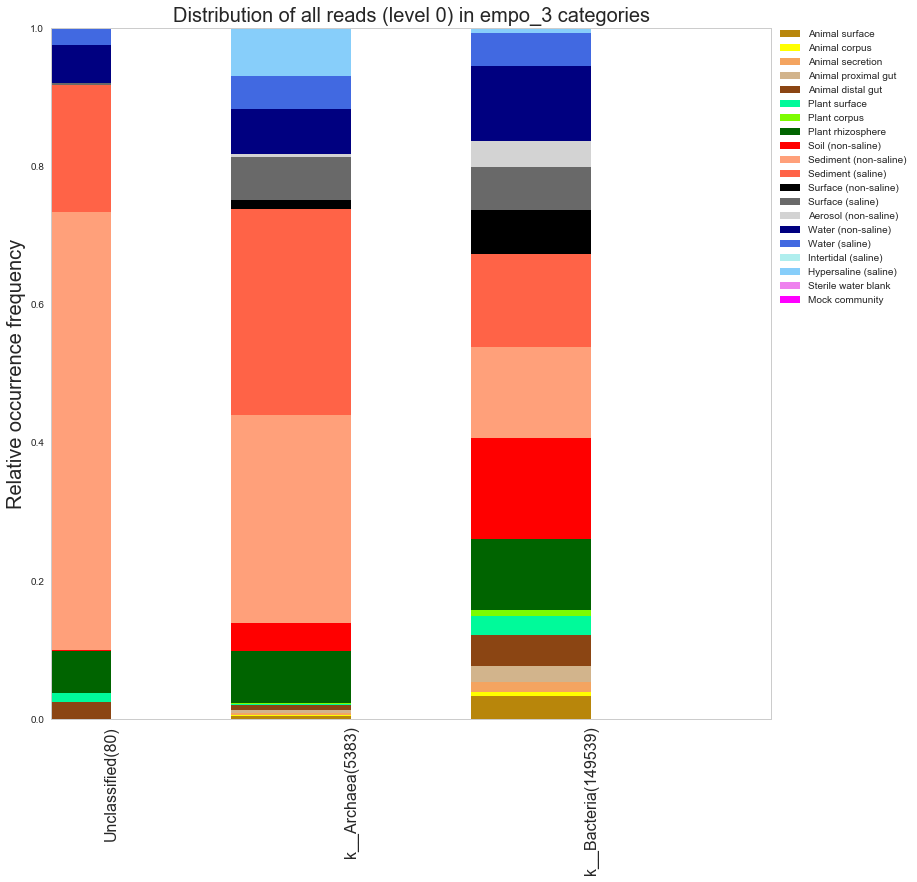

In [19]:
fig=PlotTaxEnv(result,numperclass,0,reorder=True)

# just bacteria

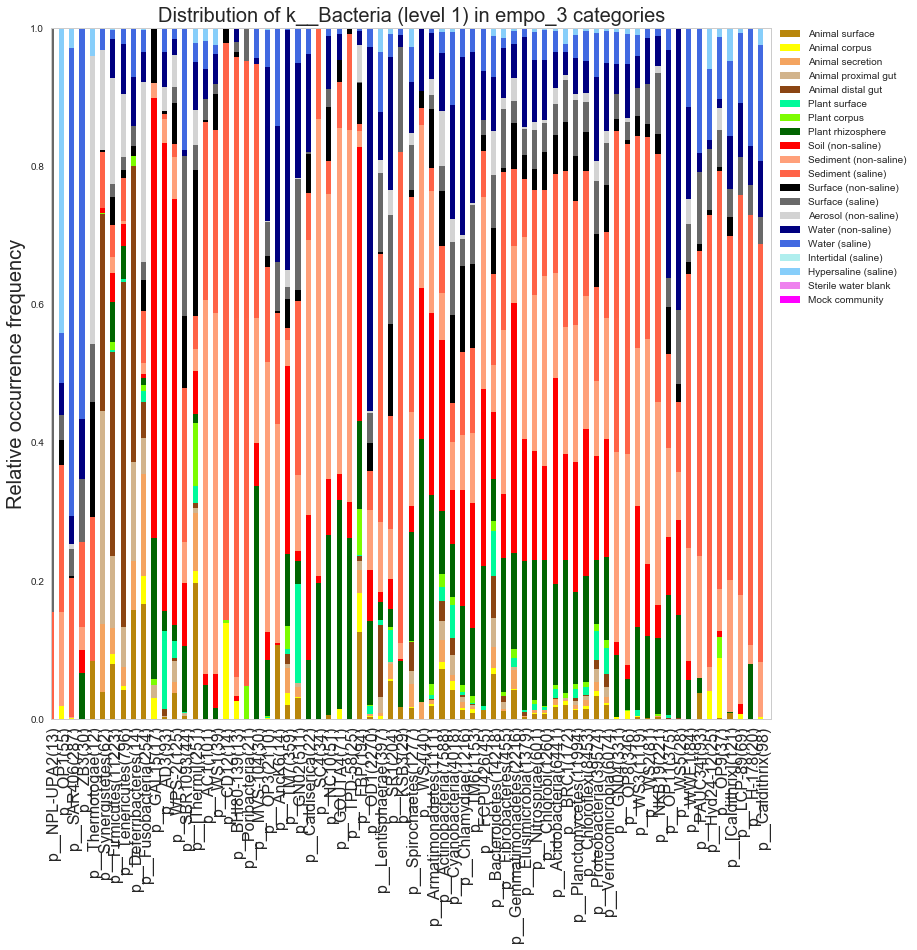

In [20]:
fig=PlotTaxEnv(result,numperclass,1,'k__Bacteria',reorder=True)

## Firmicutes

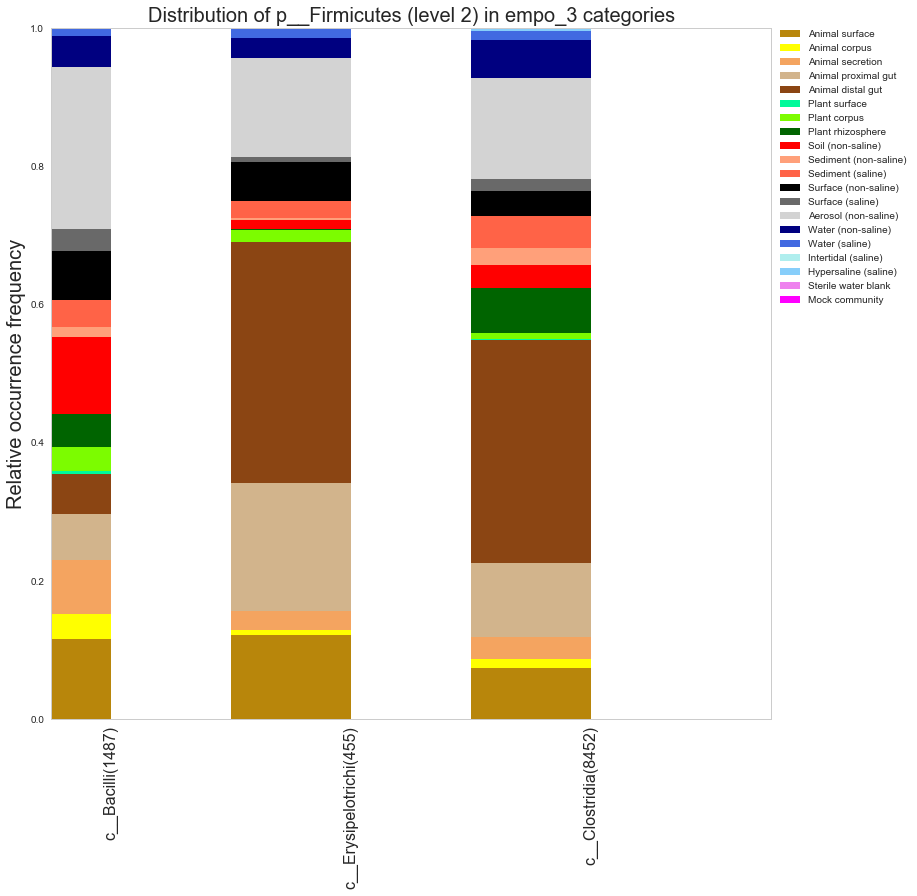

In [21]:
fig=PlotTaxEnv(result,numperclass,2,'p__Firmicutes',reorder=True)

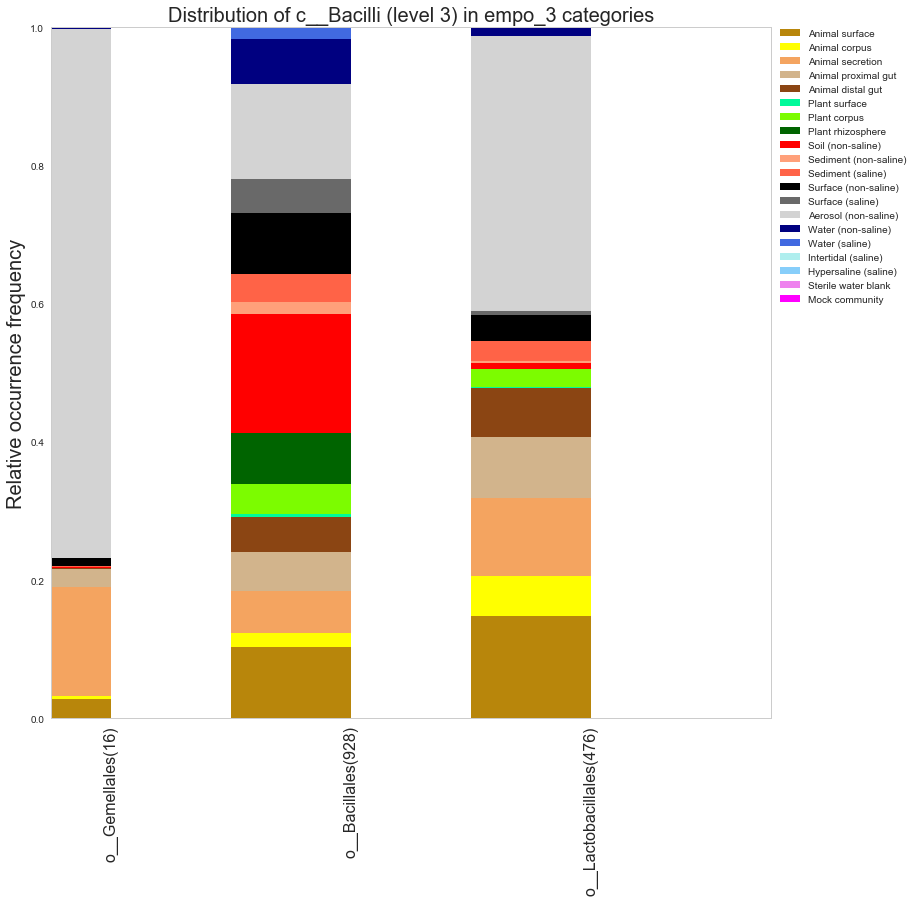

In [22]:
fig=PlotTaxEnv(result,numperclass,3,'c__Bacilli',reorder=True)

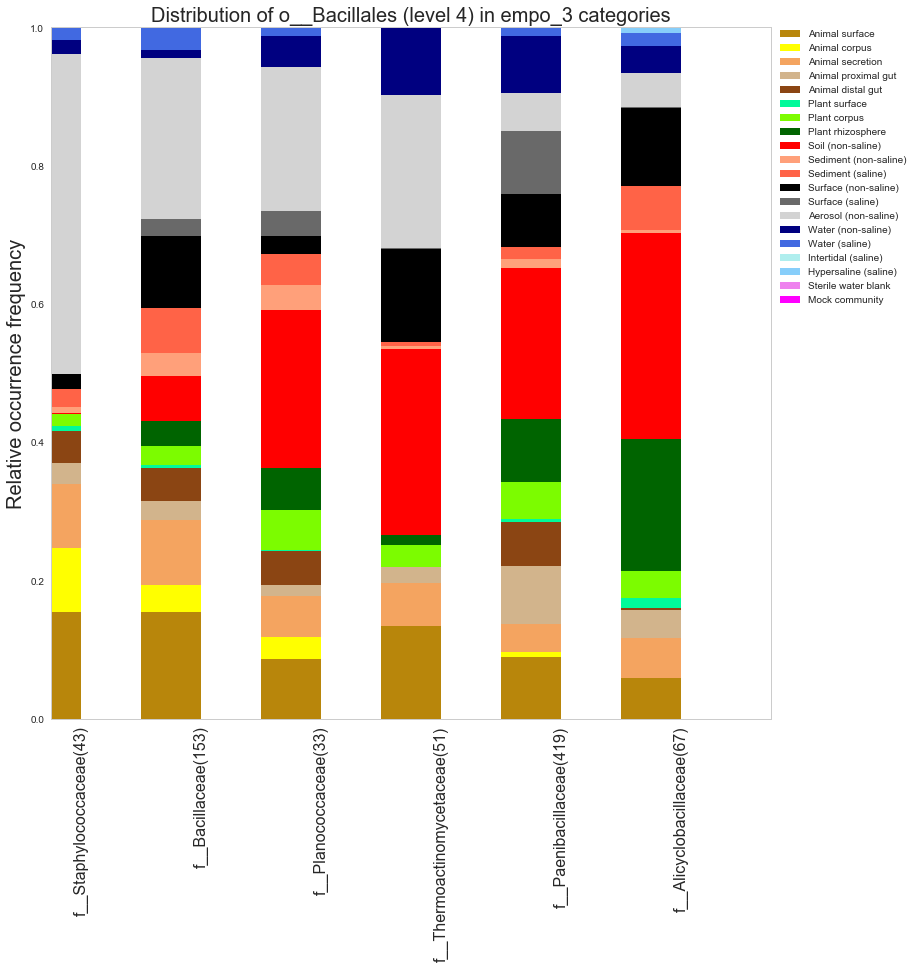

In [23]:
fig=PlotTaxEnv(result,numperclass,4,'o__Bacillales',reorder=True)

## Moraxella shows genus specific habitats

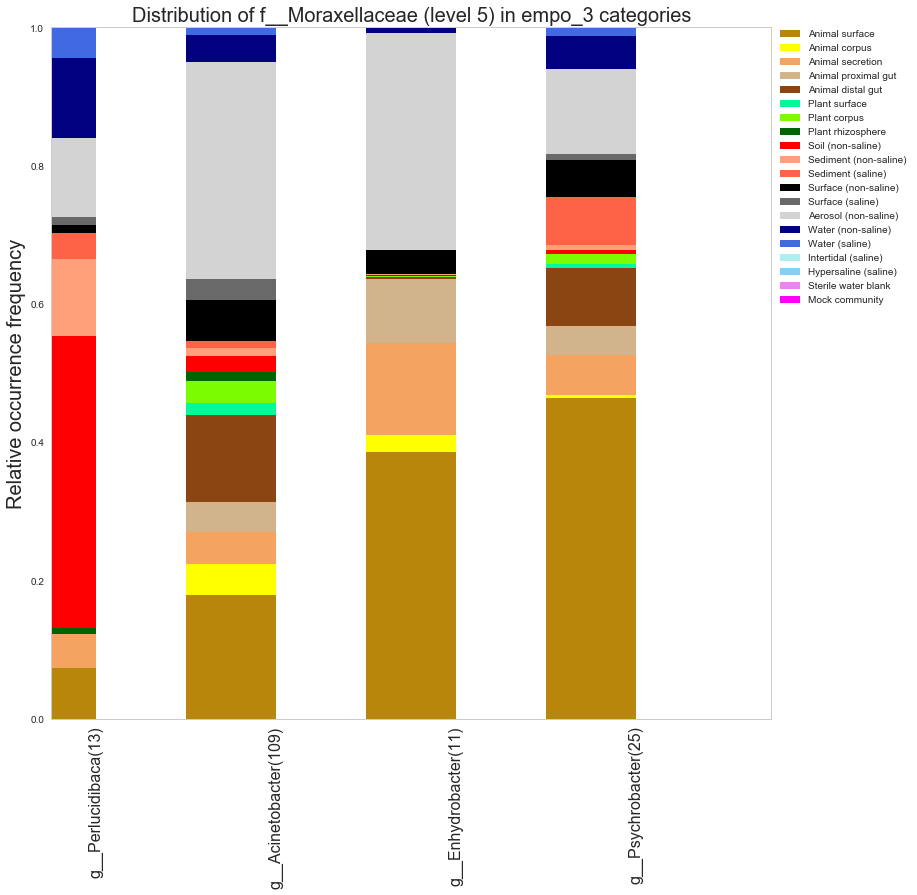

In [24]:
fig=PlotTaxEnv(result,numperclass,5,'f__Moraxellaceae',reorder=True)

# looking at low level total bacteria distribution

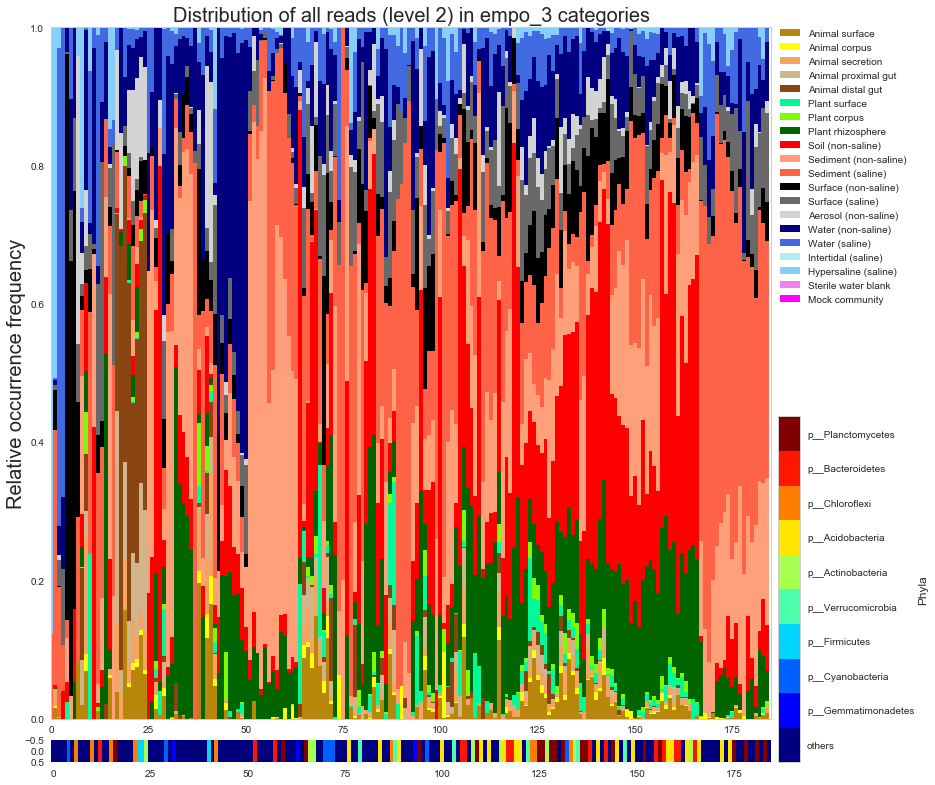

In [25]:
fig=PlotTaxEnv(result,numperclass,2,reorder=True,all_phyla=all_phyla, showx=False)

In [26]:
fig.savefig('class-level-distribution.pdf', bbox_inches='tight')

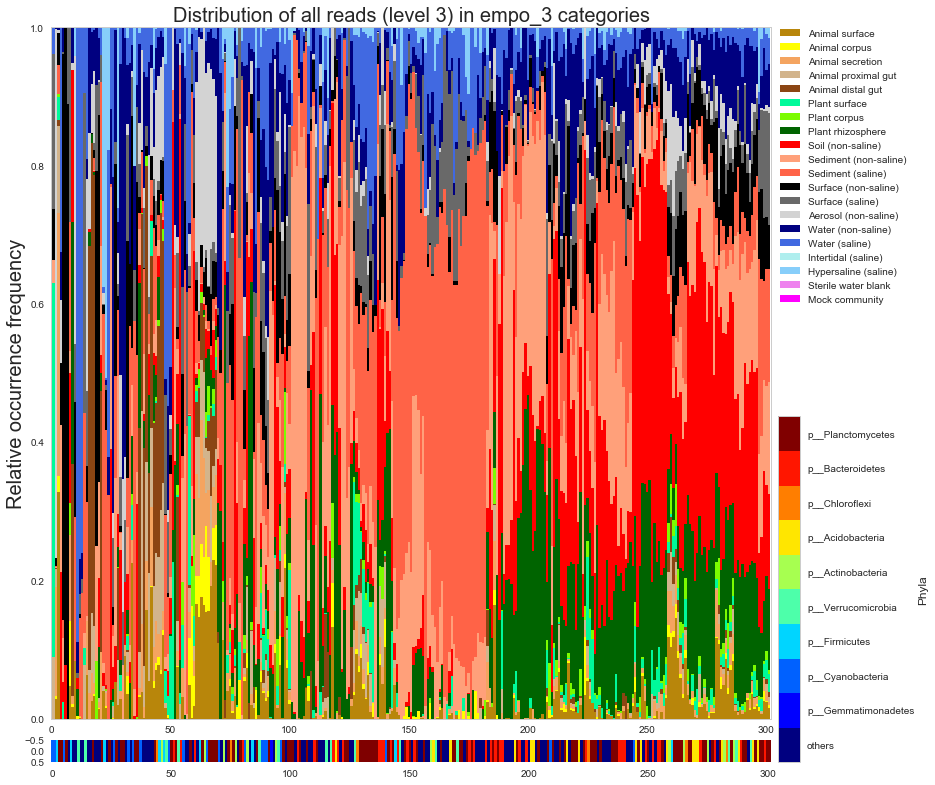

In [27]:
fig=PlotTaxEnv(result,numperclass,3,reorder=True,showx=False,all_phyla=all_phyla)

In [28]:
fig.savefig('order-level-distribution.pdf', bbox_inches='tight')

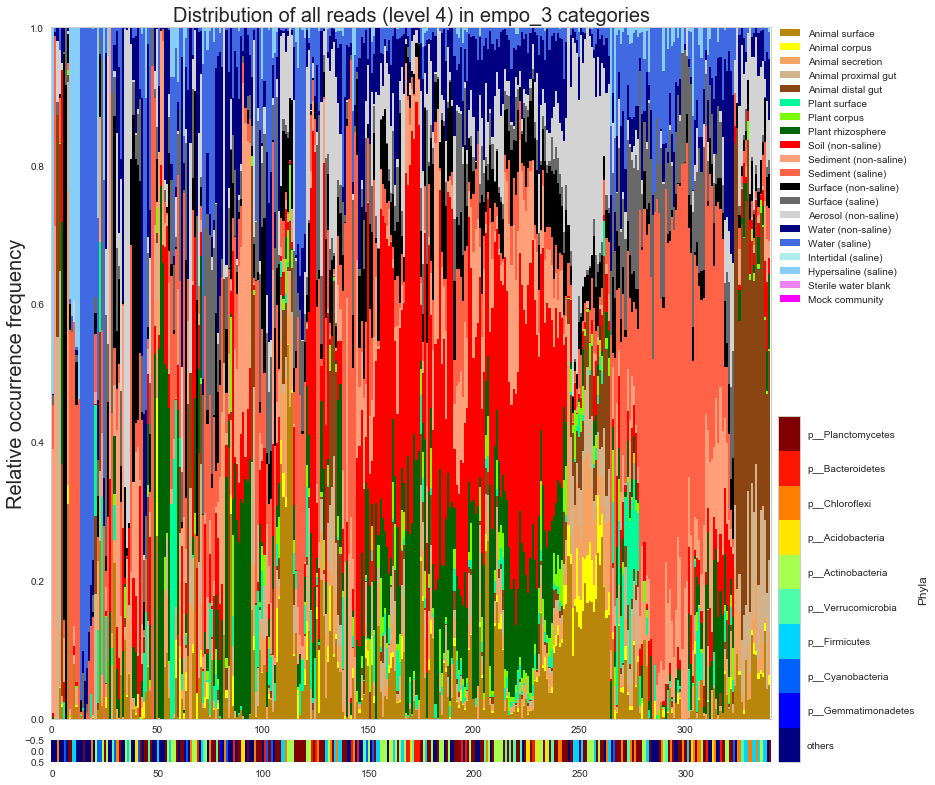

In [29]:
fig=PlotTaxEnv(result,numperclass,4,reorder=True,showx=False,all_phyla=all_phyla)

In [30]:
fig.savefig('family-level-distribution.pdf',bbox_inches='tight')

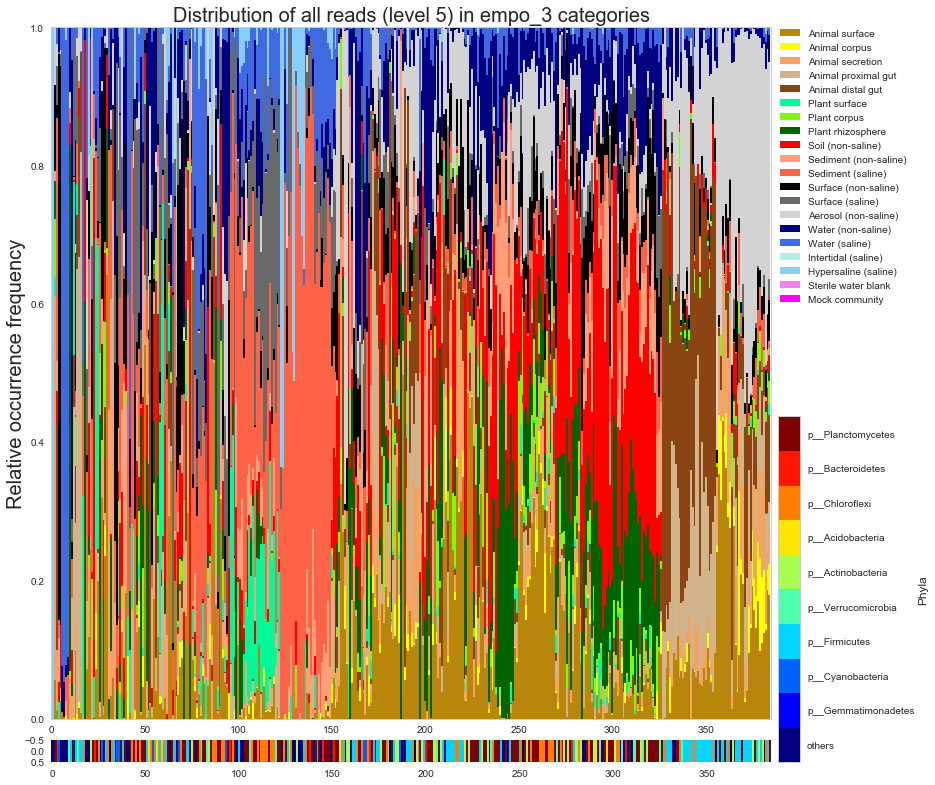

In [31]:
fig=PlotTaxEnv(result,numperclass,5,reorder=True,showx=False,all_phyla=all_phyla)

In [32]:
fig.savefig('genus-level-distribution.pdf', bbox_inches='tight')

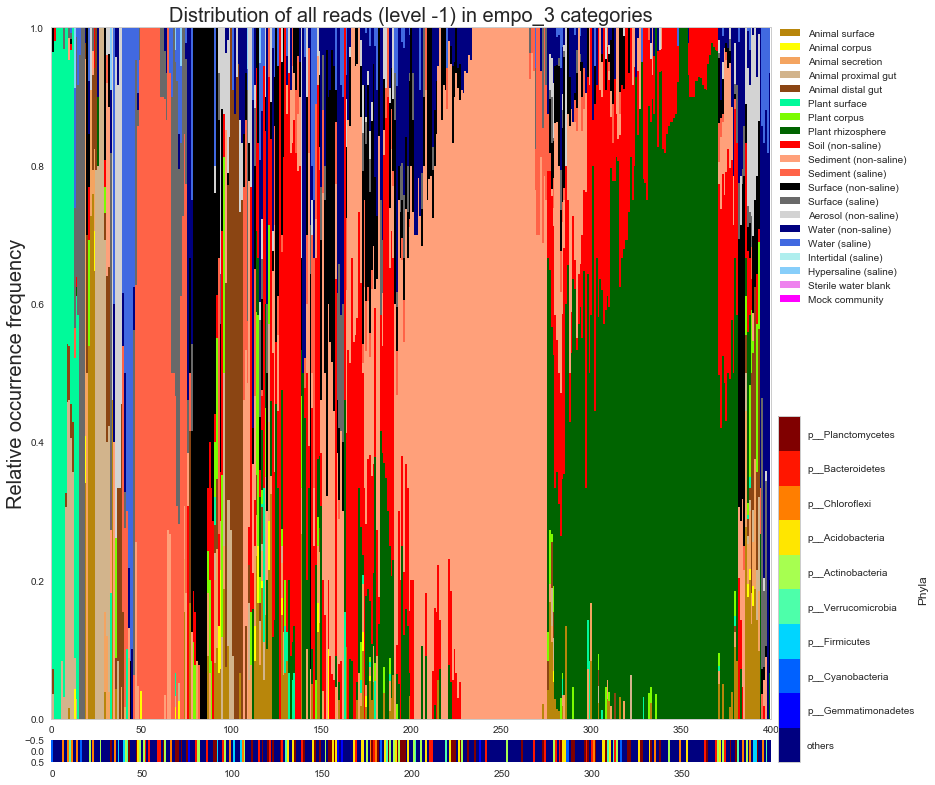

In [33]:
fig=PlotTaxEnv(otu_result, otu_numperclass, level=-1, reorder=True, showx=False, num_otu=400, all_phyla=all_phyla)

In [34]:
fig.savefig('otu-level-distribution-400.pdf',bbox_inches='tight')

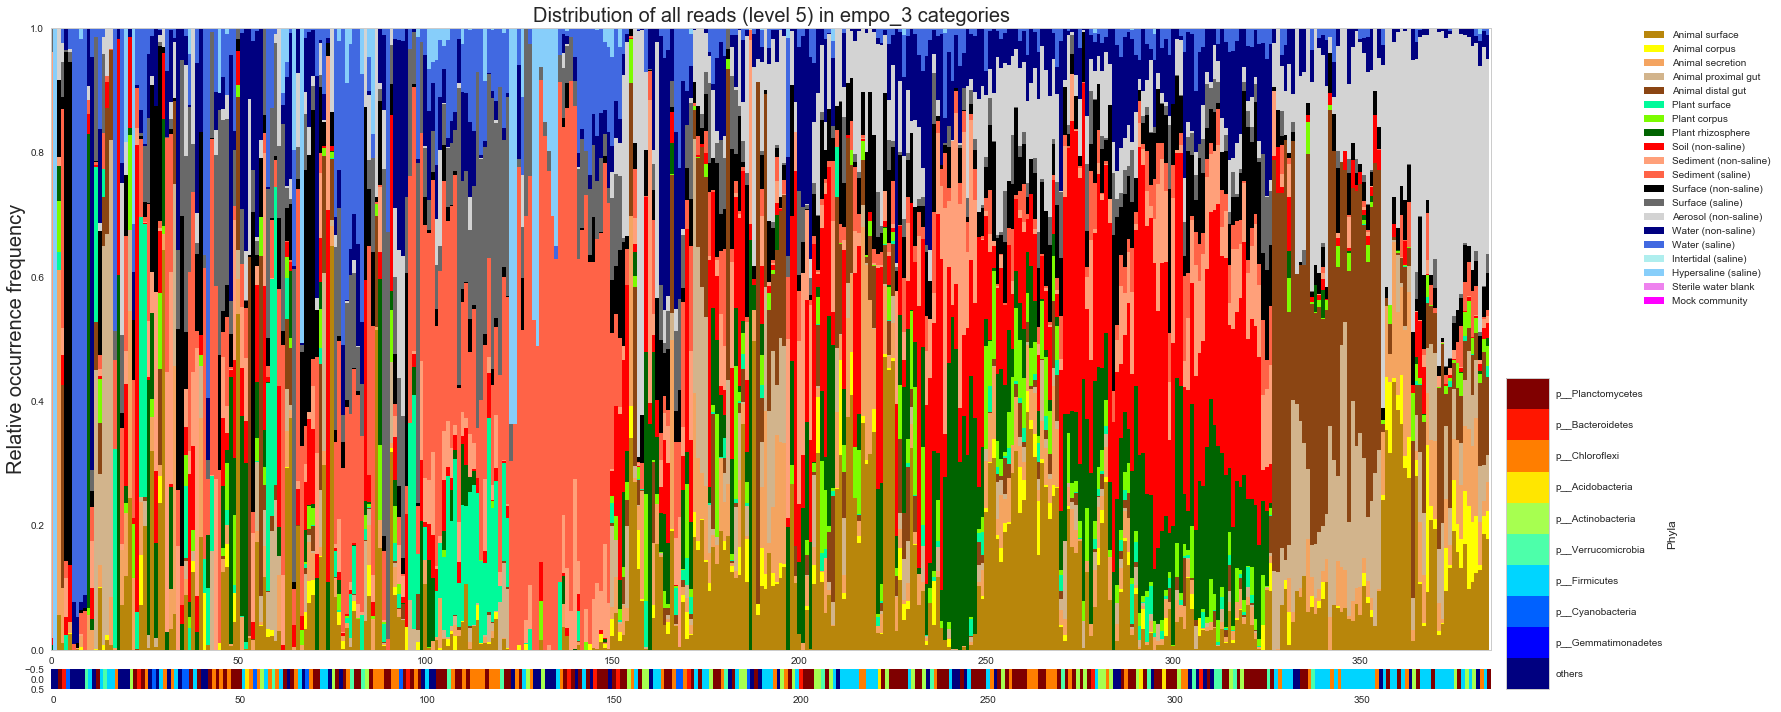

In [35]:
fig=PlotTaxEnv(result, numperclass, 5, reorder=True, showx=False, all_phyla=all_phyla, wide=True)

In [36]:
fig.savefig('genus-level-distribution-wide.pdf', bbox_inches='tight')

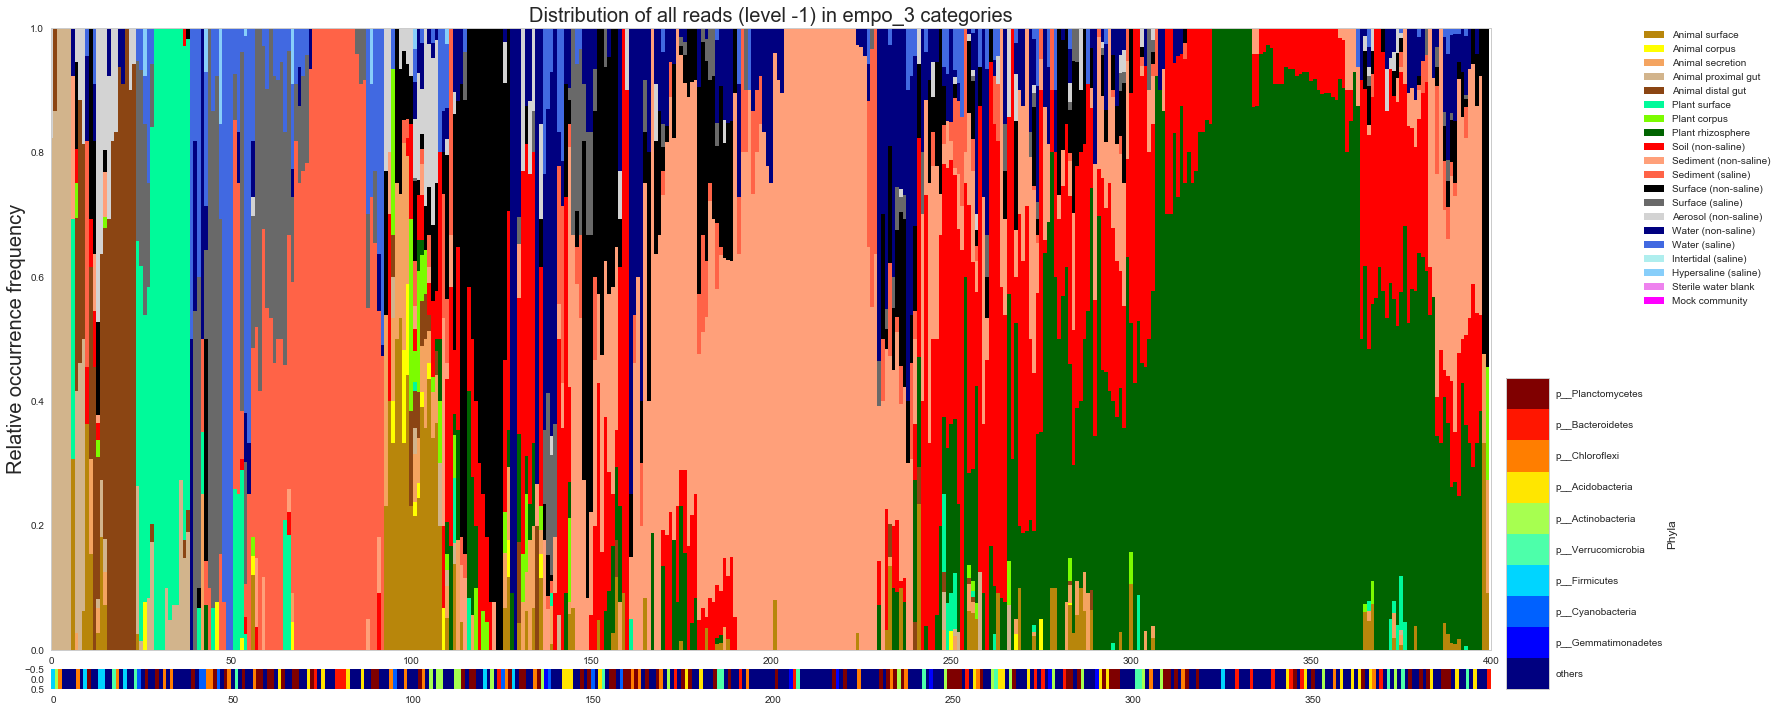

In [37]:
fig=PlotTaxEnv(otu_result, otu_numperclass, level=-1, reorder=True, showx=False, num_otu=400, all_phyla=all_phyla, wide=True)

In [38]:
fig.savefig('otu-level-distribution-400-wide.pdf',bbox_inches='tight')

# Entropy analysis
looking at the shannon entropy- low means 1 dominant empo category, high means all are ~equal
we would expect lower entropy for high resolution taxonomic assignment (Genus) compared to low resolution (Class)

In [38]:
def GetEntropy(result,level,minbacteria=10):
    """
    Get the sorted list of entropy per taxa group

    input:
    result :
    level : int
        the taxonomic level (5 is genus)
    minbacteria : int
        minimal number of bacteria per group to keep in list
        (to remove groups with not enough statistics)
    
    output:
    name : list of str
    entro : list of float
        both sorted by entropy (lowest first)
    """
    tt=filter_tax_level(result,level,minbacteria)
    entro=[]
    name=[]
    for k,v in tt.items():
        name.append(k)
        entro.append(skbio.diversity.alpha.shannon(np.array(v*10000,dtype=int)))

    si=np.argsort(entro)
    entro=[entro[i] for i in si]
    name=[name[i] for i in si]
    reducedname=[]
    for cname in name:
        reducedname.append(cname.split(';')[-2])
    return name,entro,reducedname

In [39]:
def GetOTUEntropy(otu_result):
    """
    Get the sorted list of entropy per taxa group

    input:
    result :
    level : int
        the taxonomic level (5 is genus)
    minbacteria : int
        minimal number of bacteria per group to keep in list
        (to remove groups with not enough statistics)
    
    output:
    name : list of str
    entro : list of float
        both sorted by entropy (lowest first)
    """
    entro=[]
    name=[]
    for k,v in otu_result.items():
        name.append(k)
        entro.append(skbio.diversity.alpha.shannon(np.array(v*10000,dtype=int)))

    si=np.argsort(entro)
    entro=[entro[i] for i in si]
    name=[name[i] for i in si]
    return name,entro

In [40]:
name,entro,reducedname=GetEntropy(result,5,10)

In [41]:
otuname,otuentro=GetOTUEntropy(otu_result)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


10

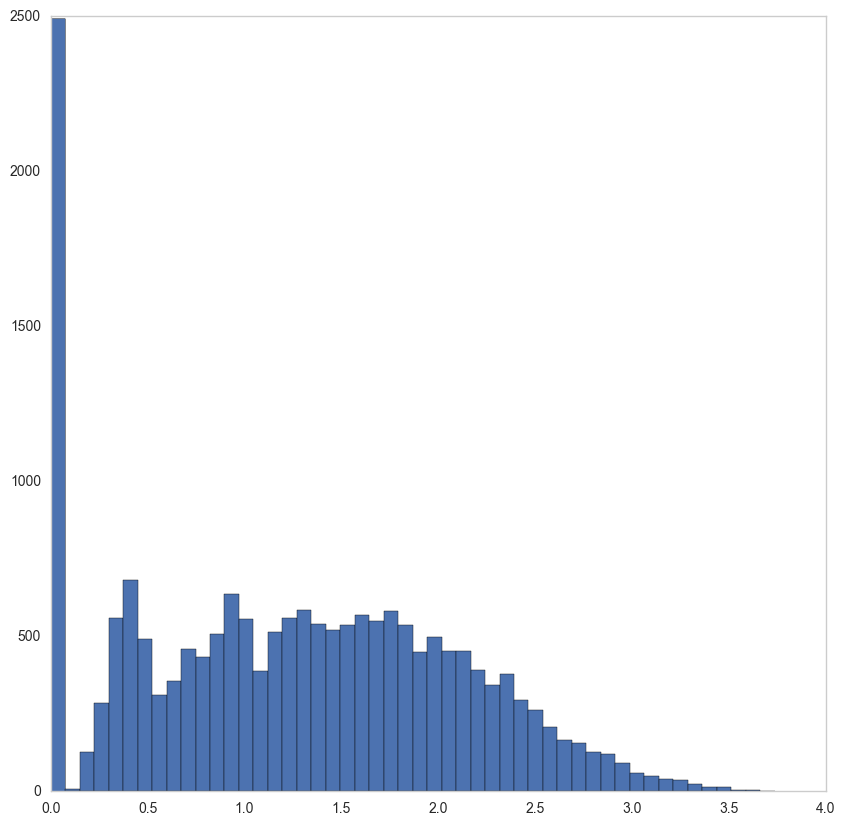

In [42]:
plt.figure()
plt.hist(otuentro,50)
tt=np.array(otuentro)
cseq=otuname[pos]
print(otu_result[cseq])
np.sum(table.data(cseq,'observation')>0)

## Sample high entropy genus

k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus


([<matplotlib.axis.XTick at 0x133abe7b8>,
 <a list of 2 Text xticklabel objects>)

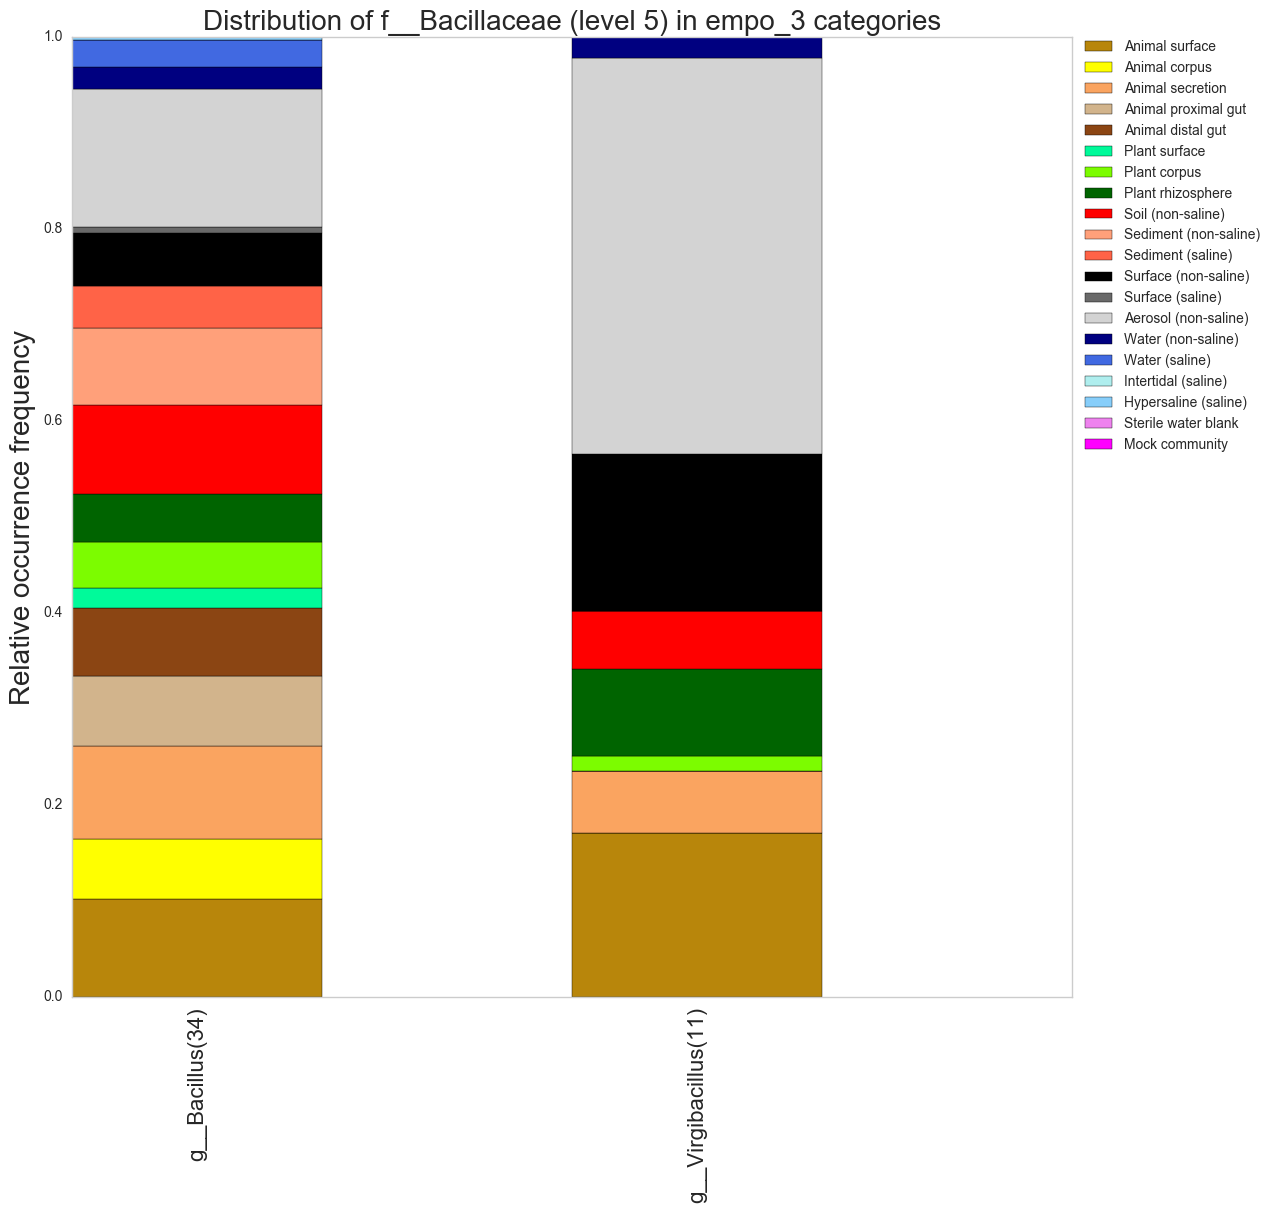

In [43]:
pos=-1
print(name[pos])
PlotTaxEnv(result,numperclass,5,reducedname[pos],reorder=True)

## Sample low entropy genus

k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__MSBL1;g__DL1A-100


([<matplotlib.axis.XTick at 0x1335e85c0>,
 <a list of 2 Text xticklabel objects>)

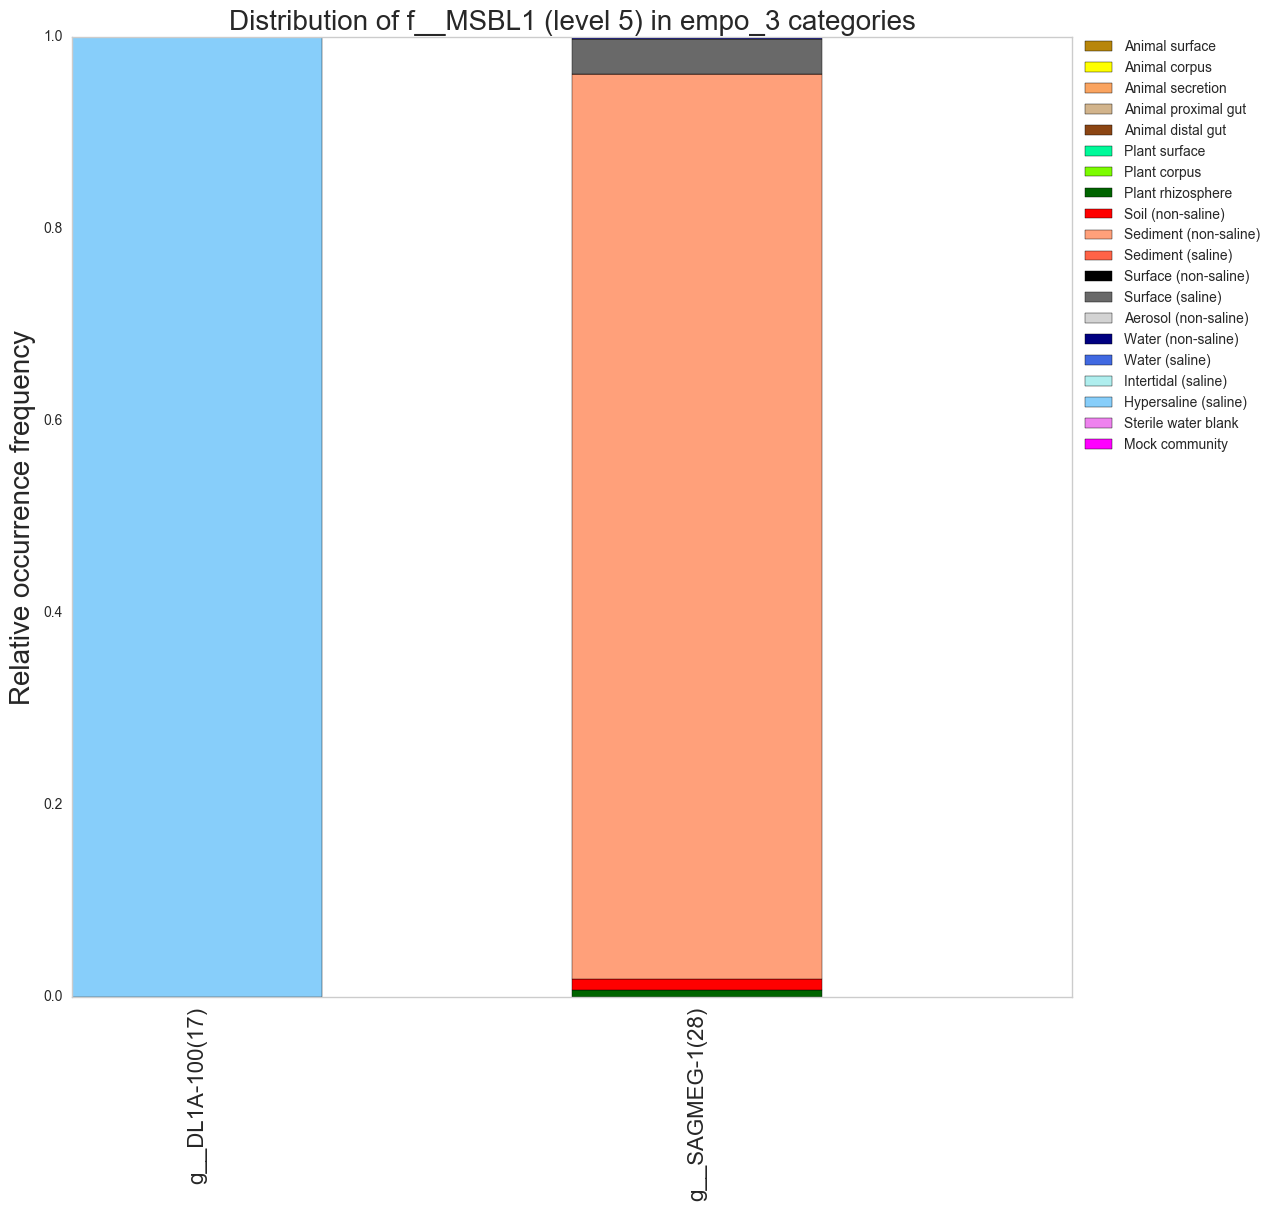

In [44]:
pos=0
print(name[pos])
PlotTaxEnv(result,numperclass,5,reducedname[pos],reorder=True)

## entropy is higher!! at lower taxonomic levels!

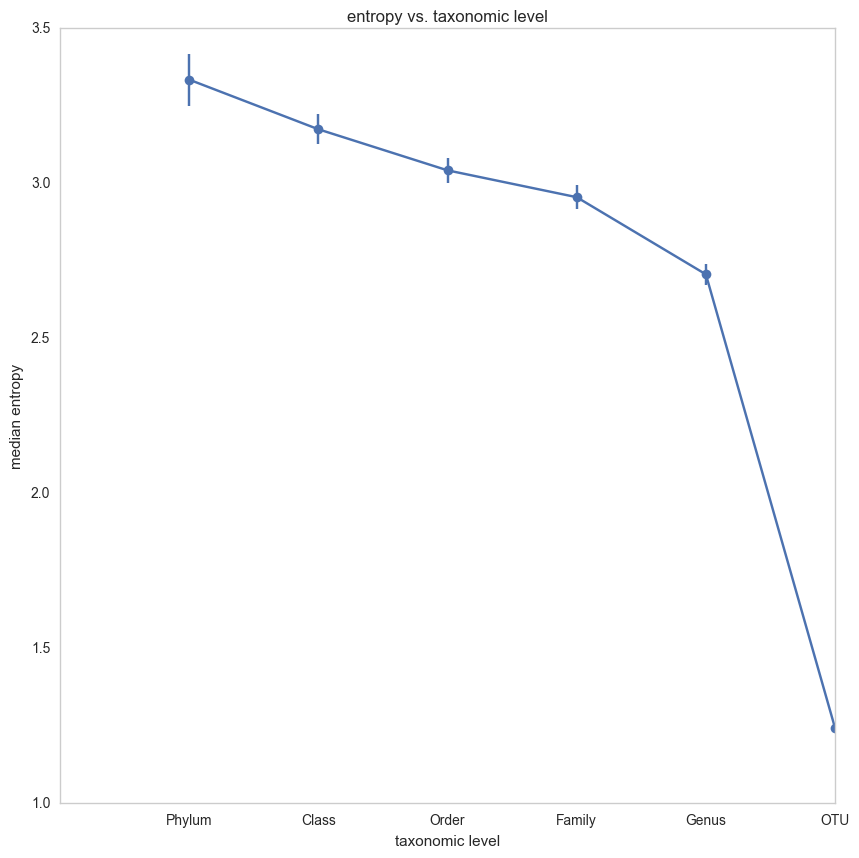

In [45]:
allentro=[]
plt.figure()
alllevel=[]
allmean=[]
allmedian=[]
allerr=[]
all_weighted_mean=[]
taxranks=['Phylum','Class','Order','Family','Genus']
for clevel in np.arange(1,6):
    name,entro,reducedname=GetEntropy(result,clevel,10)
    alllevel.append(clevel)
    allmean.append(np.mean(entro))
    weighted_mean=0
    tot_otus=0
    for idx,cname in enumerate(name):
        weighted_mean += entro[idx]*numperclass[cname]
        tot_otus += numperclass[cname]
    weighted_mean = float(weighted_mean)/tot_otus
    all_weighted_mean.append(weighted_mean)
    allmedian.append(np.median(entro))
    allerr.append(np.std(entro)/np.sqrt(len(entro)))
    allentro.append(entro)
# calculate the sOTU entropy
otuname,otuentro=GetOTUEntropy(otu_result)
all_weighted_mean.append(np.mean(otuentro))
alllevel.append(6)
taxranks.append('OTU') # 'sOTU'
allerr.append(np.std(otuentro)/np.sqrt(len(otuentro)))
# plt.subplot(2,3,6)
# print(all_weighted_mean)
# print(alllevel)
# print(allerr)
# plt.errorbar(alllevel,allmean,allerr,fmt='o-')
plt.errorbar(alllevel,all_weighted_mean,allerr,fmt='o-')
plt.xlabel('taxonomic level')
plt.xlim([0,6])
plt.xticks([1,2,3,4,5,6],taxranks)
plt.ylabel('median entropy')
plt.title('entropy vs. taxonomic level')

## sanity check - looking at Class high and low entropy

In [46]:
name,entro,reducedname=GetEntropy(result,2,25)

k__Bacteria;p__OP8;c__SAW1_B6 - 0.938549


([<matplotlib.axis.XTick at 0x123bcc2e8>,
 <a list of 3 Text xticklabel objects>)

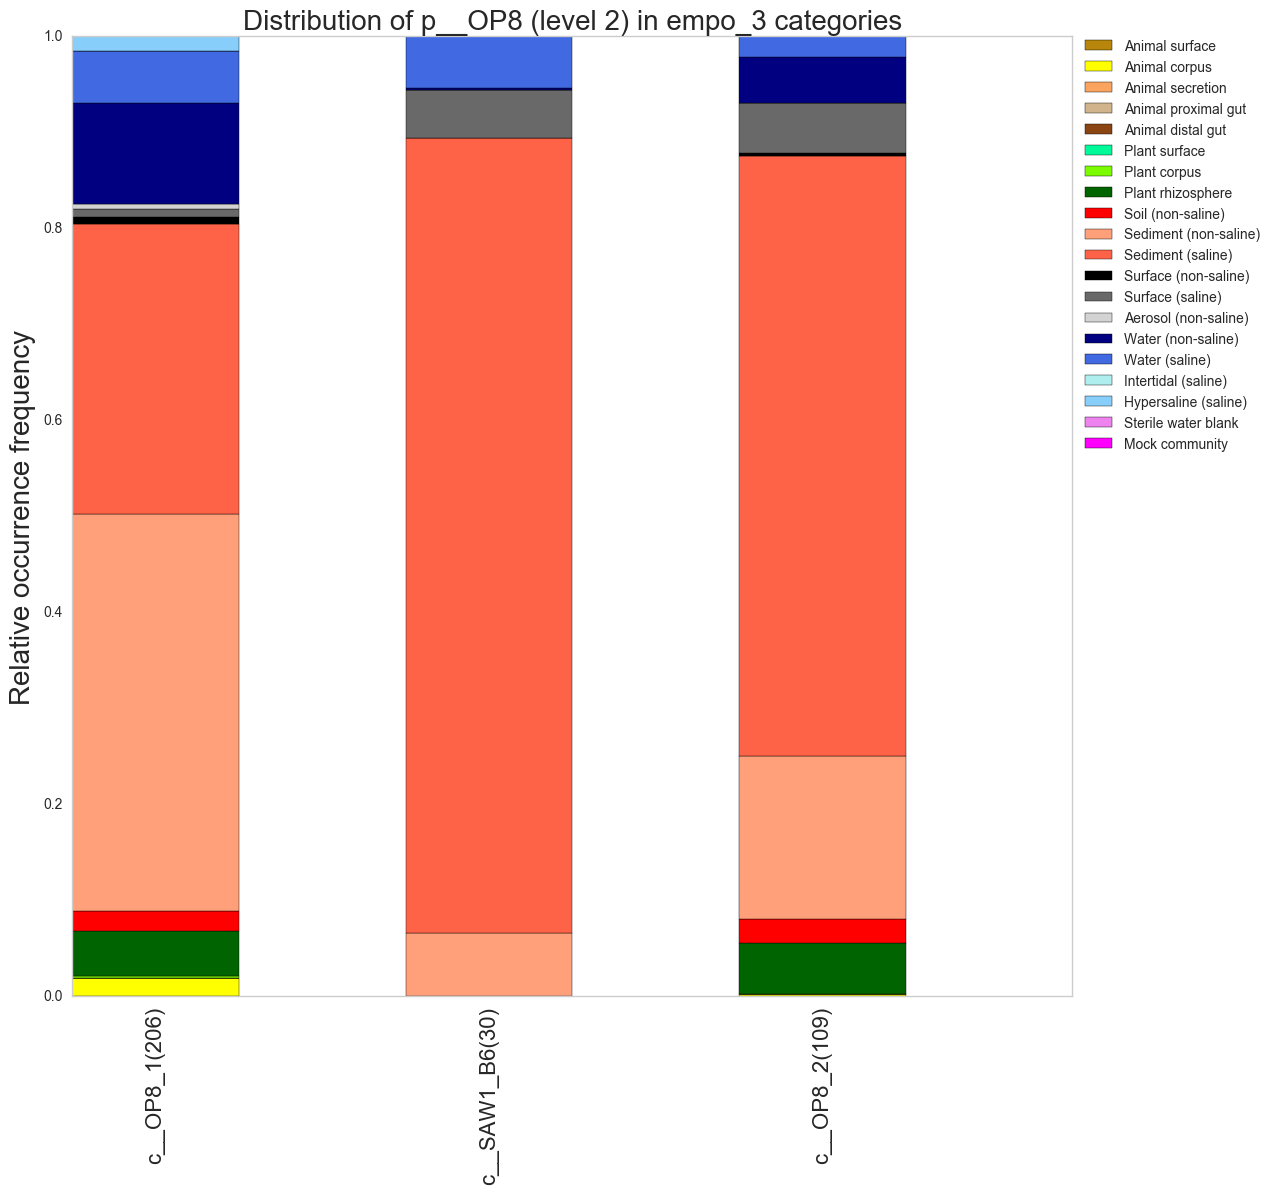

In [47]:
pos=0
print('%s - %f' % (name[pos],entro[pos]))
PlotTaxEnv(result,numperclass,2,reducedname[pos],reorder=True)

k__Bacteria;p__Cyanobacteria;c__Oscillatoriophycideae - 3.815171


([<matplotlib.axis.XTick at 0x12fc69320>,
 <a list of 7 Text xticklabel objects>)

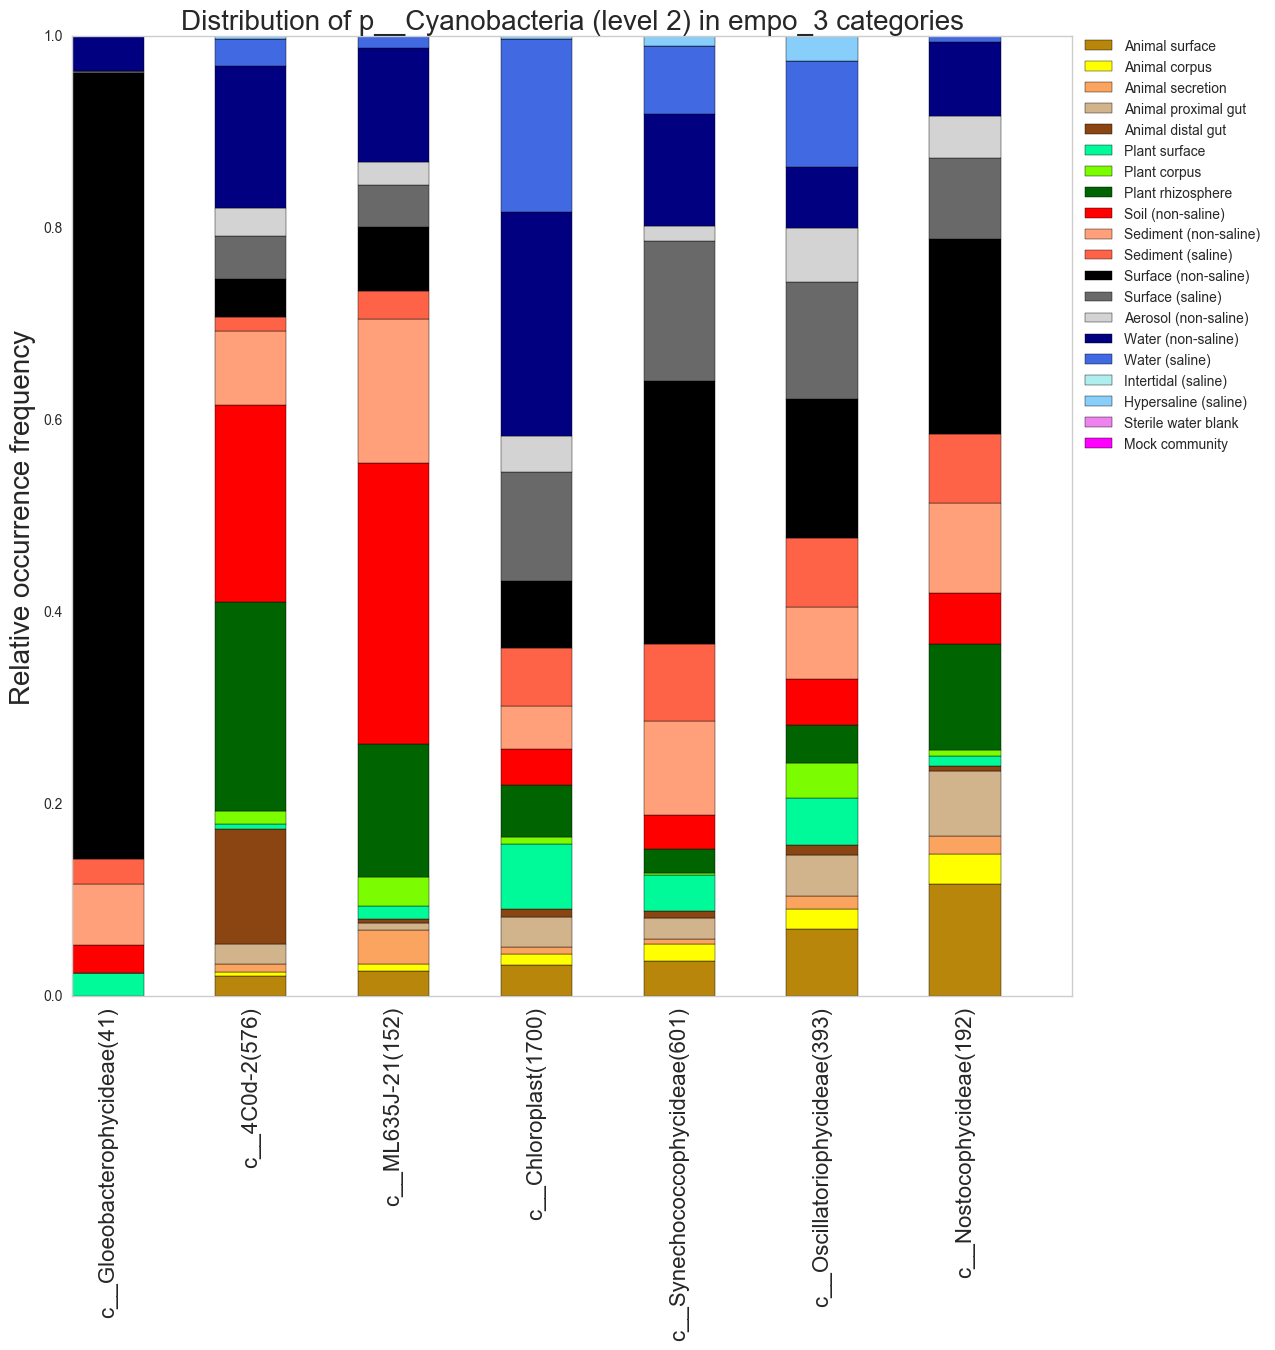

In [48]:
pos=-1
print('%s - %f' % (name[pos],entro[pos]))
PlotTaxEnv(result,numperclass,2,reducedname[pos],reorder=True)

In [49]:
all_phyla

{'p__Acidobacteria': 6,
 'p__Actinobacteria': 5,
 'p__Bacteroidetes': 7,
 'p__Chloroflexi': 8,
 'p__Cyanobacteria': 2,
 'p__Firmicutes': 3,
 'p__OP3': 1,
 'p__Planctomycetes': 9,
 'p__Proteobacteria': 10,
 'p__Verrucomicrobia': 4}

# Random permutation

In [50]:
def rand_perm_result(table,env_mat_pos):
    obs_arr=(table.ids('observation'))
    sample_arr=table.ids('sample')
    #calculating weights of constituent environment types for taxonomic bins
    permuted_otus=np.random.permutation(obs_arr) #permuting obs_arr to remove biases due to ordering of studies in orignal data
    permuted_otus2=np.random.permutation(obs_arr) #permuting obs_arr to remove biases due to ordering of studies in orignal data
    result={}
    numperclass={}
    for otuidx,otu in enumerate(permuted_otus[:]):
        otu_freq=table.data(otu,axis='observation', dense=True) #a list of frequencies of an otu across samples
        taxa_bins=[]
        env_present=[]
        sample_wt_list=np.zeros(number_env_mat)
        wt=1/float(np.count_nonzero(otu_freq)) #wt=1/(number of samples an otu is present in) 
        nz_ind=otu_freq !=0 #stores positions corresponding to samples where the otu frequency is non-zero
        for i in range(len(nz_ind)):
            if nz_ind[i]:
                env_present.append(sample_env[sample_arr[i]]) #making a list of environments each otu is present in

        taxa=table.metadata(permuted_otus2[otuidx],'observation')['taxonomy'] #extracting taxonomy information for each otu
        for i in range(len(taxa)): #loop to remove unknown classification levels (eg. 's__')
            if len(taxa[i]) <= 3:
                taxa=taxa[:i]
                break

        for i in range(len(taxa)): #loop to get all the taxonomic bins that an otu falls into 
            taxa_bins.append(';'.join(taxa))
            taxa.pop() #removing the last element of the classification
        for env in env_present: #looping over all the environments an otu is present in
            sample_wt_list[env_mat_pos[env]]=sample_wt_list[env_mat_pos[env]]+wt #adding wt to corresponding positions for each environment

        for taxa_bin in taxa_bins: #looping over all the taxa bins an otu is associated with
            if taxa_bin not in result.keys():
                result[taxa_bin]= sample_wt_list
                numperclass[taxa_bin]=1
            else:
                result[taxa_bin]=result[taxa_bin]+sample_wt_list
                numperclass[taxa_bin]+=1
    return result,numperclass

In [51]:
randres, randnum=rand_perm_result(table, env_mat_pos)

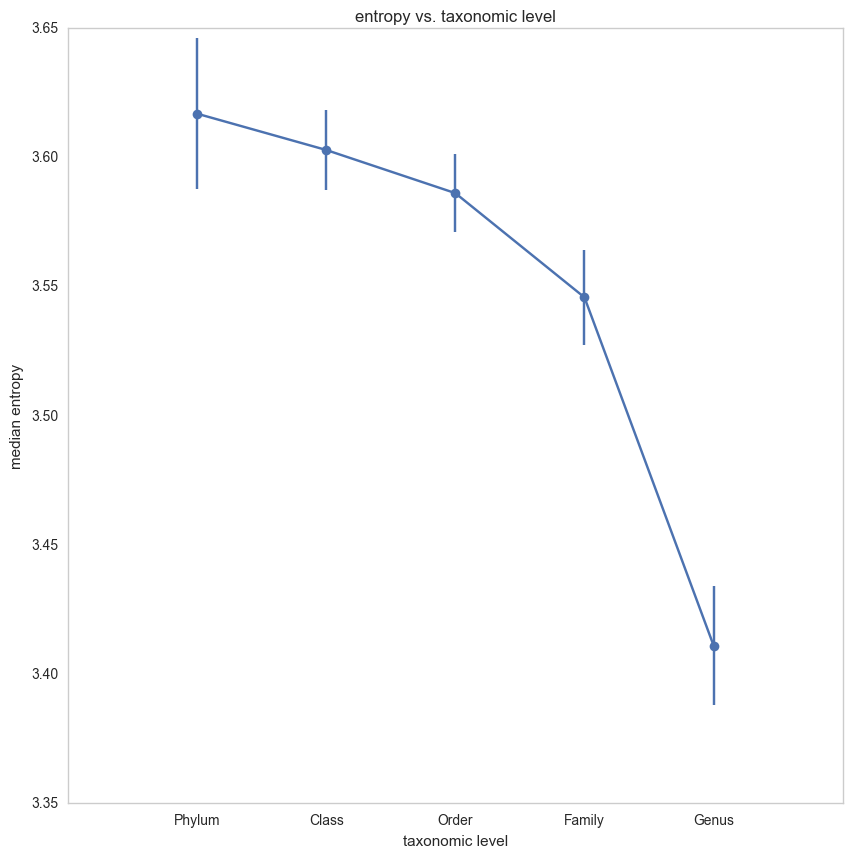

In [52]:
allentro=[]
plt.figure()
alllevel=[]
allmean=[]
allmedian=[]
allerr=[]
all_weighted_mean=[]
taxranks=['Phylum','Class','Order','Family','Genus']
for clevel in np.arange(1,6):
    name,entro,reducedname=GetEntropy(randres,clevel,10)
    alllevel.append(clevel)
    allmean.append(np.mean(entro))
    weighted_mean=0
    tot_otus=0
    for idx,cname in enumerate(name):
        weighted_mean += entro[idx]*randnum[cname]
        tot_otus += randnum[cname]
    weighted_mean = float(weighted_mean)/tot_otus
    all_weighted_mean.append(weighted_mean)
    allmedian.append(np.median(entro))
    allerr.append(np.std(entro)/np.sqrt(len(entro)))
    allentro.append(entro)

plt.errorbar(alllevel,all_weighted_mean,allerr,fmt='o-')
plt.xlabel('taxonomic level')
plt.xlim([0,6])
plt.xticks([1,2,3,4,5,6],taxranks)
plt.ylabel('median entropy')
plt.title('entropy vs. taxonomic level')

In [53]:
allentro=[]
plt.figure()
alllevel=[]
allmean=[]
allmean_rand=[]
allmedian=[]
allerr=[]
allerr_rand=[]
all_weighted_mean=[]
all_weighted_mean_rand=[]
taxranks=['Phylum','Class','Order','Family','Genus']
for clevel in np.arange(1,6):
    name,entro,reducedname=GetEntropy(result,clevel,0)
    name_rand,entro_rand,reducedname_rand=GetEntropy(randres,clevel,0)
    
    alllevel.append(clevel)
    
    allmean.append(np.mean(entro))
    allmean_rand.append(np.mean(entro_rand))
    
    weighted_mean=0
    tot_otus=0
    
    tot_otus_rand=0
    weighted_mean_rand=0
    
    for idx,cname in enumerate(name):
        weighted_mean += entro[idx]*numperclass[cname]
        tot_otus += numperclass[cname]
    
    for idx,cname in enumerate(name_rand):
        weighted_mean_rand += entro_rand[idx]*randnum[cname]
        tot_otus_rand += randnum[cname]
    
    weighted_mean = float(weighted_mean)/tot_otus
    weighted_mean_rand=float(weighted_mean_rand)/tot_otus_rand
    
    all_weighted_mean.append(weighted_mean)
    all_weighted_mean_rand.append(weighted_mean_rand)

    
    allerr.append(np.std(entro)/np.sqrt(len(entro)))
    allerr_rand.append(np.std(entro_rand)/np.sqrt(len(entro_rand)))
    
    allentro.append(entro)
# calculate the sOTU entropy
otuname,otuentro=GetOTUEntropy(otu_result)
all_weighted_mean.append(np.mean(otuentro))
alllevel.append(6)
taxranks.append('OTU') # 'sOTU'
allerr.append(np.std(otuentro)/np.sqrt(len(otuentro)))

## Luke's Addendum

### Entropy line graph

In [54]:
import seaborn as sns
sns.set_style('ticks', {'xtick.direction': u'in', 'ytick.direction': u'in'})

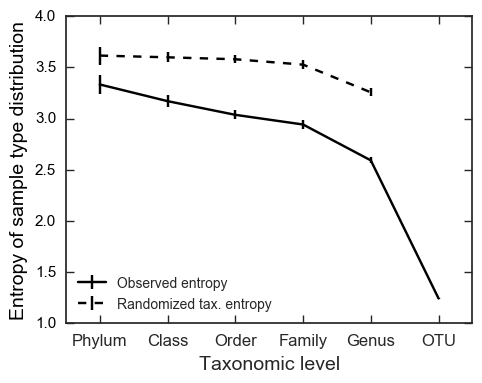

In [55]:
fig, ax1 = plt.subplots(figsize=(5,4))
ax1c = 'k'

ax1.errorbar(alllevel, all_weighted_mean, allerr,
            fmt='-o', color=ax1c, mfc='none', label='Observed entropy')
ax1.errorbar([1,2,3,4,5], all_weighted_mean_rand, allerr_rand, 
            fmt='--o', color=ax1c, mfc='none', label='Randomized tax. entropy')
ax1.set_ylabel('Entropy of sample type distribution', fontsize=14, color=ax1c) # (median +/- std. error)
for label in ax1.get_yticklabels():
    label.set_color(ax1c)
    label.set_size(11)
ax1.legend(loc=3, fontsize=10)

ax1.set_xlabel('Taxonomic level', fontsize=14)
ax1.set_xlim([0.5,6.5])
ax1.set_xticks([1,2,3,4,5,6])
ax1.set_xticklabels(taxranks, size=12)

plt.tight_layout()
#fig.savefig("entropyperlevel.pdf", bbox_inches='tight')

In [56]:
df_obs = pd.DataFrame({'taxlevel': alllevel, 'mean': all_weighted_mean, 'std': allerr})
df_rand = pd.DataFrame({'taxlevel': [1,2,3,4,5], 'mean': all_weighted_mean_rand, 'std': allerr_rand})
df_obs.to_csv('tax_entropy_obs.csv')
df_rand.to_csv('tax_entropy_rand.csv')

### Entropy plus NODF line graph

In [56]:
df_nodf = pd.read_excel('~/emp/analyses-nestedness/nodf_obs_null.xlsx')

In [57]:
df_nodf

,TAXONOMIC_LEVEL,NODF_NULL_MEAN,NODF_NULL_STDEV,NODF_OBSERVED
0,phylum,0.288235,0.009280,0.841151
1,class,0.248294,0.006833,0.732128
2,order,0.218912,0.005712,0.582832
3,family,0.176880,0.005190,0.434909
4,genus,0.060308,0.003726,0.256224
5,otu,0.004777,0.000624,0.039439


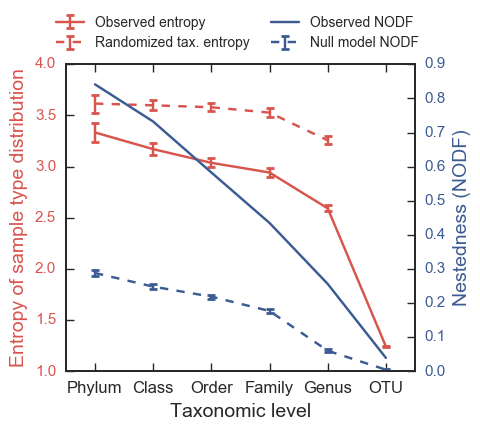

In [58]:
fig, ax1 = plt.subplots(figsize=(5,4))
ax1c = sns.xkcd_rgb['pale red']
ax2c = sns.xkcd_rgb['denim blue']

ax1.errorbar(alllevel, all_weighted_mean, allerr,
            fmt='-o', capthick=2, color=ax1c, mfc='none', label='Observed entropy')
ax1.errorbar([1,2,3,4,5], all_weighted_mean_rand, allerr_rand, 
            fmt='--o', capthick=2, color=ax1c, mfc='none', label='Randomized tax. entropy')
ax1.set_ylabel('Entropy of sample type distribution', fontsize=14, color=ax1c) # (median +/- std. error)
for label in ax1.get_yticklabels():
    label.set_color(ax1c)
    label.set_size(11)
ax1.legend(loc='upper center', bbox_to_anchor=(0.25,1.2), fontsize=10)

ax2 = ax1.twinx()
ax2.plot([1,2,3,4,5,6], df_nodf.NODF_OBSERVED,
         '-o', color=ax2c, mfc='none', label='Observed NODF')
ax2.errorbar([1,2,3,4,5,6], df_nodf.NODF_NULL_MEAN, df_nodf.NODF_NULL_STDEV,
         fmt='--o', capthick=2, color=ax2c, mfc='none', label='Null model NODF')
ax2.set_ylabel('Nestedness (NODF)', fontsize=14, color=ax2c) # (median +/- std. error)
for label in ax2.get_yticklabels():
    label.set_color(ax2c)
    label.set_size(11)
ax2.legend(loc='upper center', bbox_to_anchor=(0.8,1.2), fontsize=10)

ax1.set_xlabel('Taxonomic level', fontsize=14)
ax1.set_xlim([0.5,6.5])
ax1.set_xticks([1,2,3,4,5,6])
ax1.set_xticklabels(taxranks, size=12)

plt.tight_layout()
#fig.savefig("entropy_and_nodf.pdf", bbox_inches='tight')

### Finding highest-entropy OTUs per sample type (continued in otu_entropy.ipynb)

In [100]:
# pandas dataframe of otu name and otu entropy
df_otuentropy = pd.DataFrame(otuentro, index=otuname, columns=['entropy'])

In [101]:
# pandas dataframe of empo_3 distribution
df_empodist = pd.DataFrame(otu_result).transpose()
df_empodist.columns = env_mat_list

In [102]:
# merge dataframes
df_otuentropyempo = pd.merge(df_otuentropy, df_empodist, left_index=True, right_index=True)

In [111]:
# write to csv
df_otuentropyempo.to_csv('~/emp/analyses-otus/otu_entropy_empo.csv')